In [ ]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install scipy
!pip install gdown


In [1]:

# Import portion of a package
import matplotlib.pyplot as plt  # Most common visualization package that a lot of others are based on

# Import full packages under custom name
import numpy as np  # Common package for numerical methods
import pandas as pd  # Common package for data storeage/manipulation
import seaborn as sns  # Common package for statistical visualizations

# Import portion of a package
import scipy.stats as stats
from sklearn.impute import SimpleImputer as Imputer  # Specific function from common machine learning package\

#more packages
import gdown


In [2]:
# File ID from your link (assuming this is the cleaned dataset)
file_id = "13elVDJJ6JUH2gsj36CxPjkLryE2rnl-r"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
gdown.download(url, "flight_data.csv", quiet=False)

# Now load it
flight_data = pd.read_csv("flight_data.csv")
print(flight_data.shape)
print(flight_data.head())

Downloading...
From (original): https://drive.google.com/uc?id=13elVDJJ6JUH2gsj36CxPjkLryE2rnl-r
From (redirected): https://drive.google.com/uc?id=13elVDJJ6JUH2gsj36CxPjkLryE2rnl-r&confirm=t&uuid=d29e5892-2890-481e-bd9b-4a8c0f91412a
To: /content/flight_data.csv
100%|██████████| 1.32G/1.32G [00:14<00:00, 87.9MB/s]


(7546988, 32)
   YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK  MKT_CARRIER_AIRLINE_ID  \
0  2024        1      1             1            1                   19393   
1  2024        1      1             1            1                   19393   
2  2024        1      1             1            1                   19393   
3  2024        1      1             1            1                   19393   
4  2024        1      1             1            1                   19393   

   ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_NAME  DEST_AIRPORT_ID  \
0              10140                1014005  Albuquerque, NM            10423   
1              10140                1014005  Albuquerque, NM            10423   
2              10140                1014005  Albuquerque, NM            10800   
3              10140                1014005  Albuquerque, NM            10821   
4              10140                1014005  Albuquerque, NM            11259   

   ...  CANCELLATION_CODE CRS_

In [3]:

df = flight_data.copy()
print (df.head())
print(df.columns.tolist())

   YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK  MKT_CARRIER_AIRLINE_ID  \
0  2024        1      1             1            1                   19393   
1  2024        1      1             1            1                   19393   
2  2024        1      1             1            1                   19393   
3  2024        1      1             1            1                   19393   
4  2024        1      1             1            1                   19393   

   ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_NAME  DEST_AIRPORT_ID  \
0              10140                1014005  Albuquerque, NM            10423   
1              10140                1014005  Albuquerque, NM            10423   
2              10140                1014005  Albuquerque, NM            10800   
3              10140                1014005  Albuquerque, NM            10821   
4              10140                1014005  Albuquerque, NM            11259   

   ...  CANCELLATION_CODE CRS_ELAPSED_TIME  

In [ ]:
"""
minimize sum of (epsilon?) (frequency * average * passengers)
st.
    ...

optimization problem in words
- frequency = probability of flight being delayed
- average = expected delay time (in minutes)
- passengers = number of passengers taking that flight
- possible constraints for passengers:
  - arrival/depaarture time being between certain times
  - flight duration being shorter than x hours
  - groups of passengers staying together (ie families)
  - max number of extra seats on flights
  - need to get to destination by a certain time
  - airline?
  - any connecting flights must have at least a 1 hour buffer for connecting purposes


info needed about the set of flights:
- number of seats available (this is a made up number)
- frequency
- average
- arrival/departure time/day/month/year
- flight duration
- destination/origin airport/city
- airline

"""

In [4]:
"""
calculating average and frequency of delay for each flight with a different origin-destination city pair

"""
# Boolean series: True if there is a delay
def compute_delay_stats(group):
    delayed = group['DEP_DELAY_NEW'] > 0

    # Probability of delay
    prob_delay = delayed.sum() / len(group)

    # Average delay (only for delayed rows)
    if delayed.sum() > 0:
        avg_delay = group.loc[delayed, 'DEP_DELAY_NEW'].mean()
    else:
        avg_delay = 0.0

    return pd.Series({'freq_delay': prob_delay, 'avg_delay': avg_delay})

# Group by origin and destination airport to calculate delay stats
delay_stats = df.groupby(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']).apply(compute_delay_stats).reset_index()

# Display
print(delay_stats.head())



   ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID  freq_delay  avg_delay
0              10135            10397    0.259587  51.750000
1              10135            10693    0.247619  45.307692
2              10135            11057    0.282161  76.173252
3              10135            11292    0.255814  51.181818
4              10135            11697    0.283951  38.652174


/tmp/ipython-input-2011116902.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  delay_stats = df.groupby(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']).apply(compute_delay_stats).reset_index()


In [7]:
"""

for the optimization problem, assuming starting point is LA. to get a network of flights, took the top 5
most frequent destinations from LA, from those 5 took the top 5, and from those took the top 2 to get a
solid variety of cities.

"""
start_airport = 12892  # LA

#calculating top 5 destinations from LA
from_LA = df[df['ORIGIN_AIRPORT_ID'] == start_airport]
top5_first_leg = from_LA['DEST_AIRPORT_ID'].value_counts().head(5).index.tolist()
print("Top 5 destinations from LA:", top5_first_leg)

#from  those top 5 destinations, calculating their top 5 destinations excluding LA
second_leg = {}
second_leg_airports = set()
for origin in top5_first_leg:
    flights_from_origin = df[df['ORIGIN_AIRPORT_ID'] == origin]
    top5 = flights_from_origin[flights_from_origin['DEST_AIRPORT_ID'] != start_airport] \
            ['DEST_AIRPORT_ID'].value_counts().head(5).index.tolist()
    second_leg[origin] = top5
    second_leg_airports.update(top5)

print("\nSecond leg top 5 destinations from each first leg destination:")
for origin, dests in second_leg.items():
    print(f"{origin} -> {dests}")

# from the top 5 of the top 5, doing the top 2 except the origin airport can't be the original top 5
third_leg = {}
first_leg_set = set(top5_first_leg)

for origin, dests in second_leg.items():
    for second_leg_dest in dests:
        # Skip if this second-leg airport is also a first-leg airport
        if second_leg_dest in first_leg_set:
            continue

        flights_from_second = df[df['ORIGIN_AIRPORT_ID'] == second_leg_dest]

        # Build set of airports to exclude
        exclude_set = first_leg_set | second_leg_airports | {second_leg_dest, start_airport}

        # Pick top 2 destinations after excluding forbidden airports
        top2 = (
            flights_from_second[
                ~flights_from_second['DEST_AIRPORT_ID'].isin(exclude_set)
            ]['DEST_AIRPORT_ID']
            .value_counts()
            .head(2)
            .index
            .tolist()
        )

        if top2:
            third_leg[second_leg_dest] = top2

print("\nThird leg top 2 destinations:")
for origin, dests in third_leg.items():
    print(f"{origin} -> {dests}")


Top 5 destinations from LA: [14771, 12889, 12478, 11292, 14747]

Second leg top 5 destinations from each first leg destination:
14771 -> [14747, 12478, 14679, 12889, 11292]
12889 -> [11292, 14107, 14679, 14747, 11298]
12478 -> [14771, 10721, 13303, 13204, 14492]
11292 -> [14107, 12889, 14869, 14747, 13930]
14747 -> [10299, 14057, 14107, 11292, 12889]

Third leg top 2 destinations:
14679 -> [14831, 14893]
14107 -> [14908, 10397]
11298 -> [12266, 10397]
10721 -> [11278, 12953]
13303 -> [10397, 12953]
13204 -> [10397, 11618]
14492 -> [10397, 12953]
14869 -> [10397, 12266]
13930 -> [12953, 11278]
10299 -> [11630, 12523]
14057 -> [14831, 14893]


In [8]:
"""
converts all the airport IDs from the previous step to cities
"""
#convert airport IDs to city names
airport_to_city = (
    df[['ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME']]
    .drop_duplicates()
    .assign(ORIGIN_CITY_NAME=lambda x: x['ORIGIN_CITY_NAME'].str.split(',').str[0])
    .set_index('ORIGIN_AIRPORT_ID')['ORIGIN_CITY_NAME']
    .to_dict()
)

def id_to_city(airport_id):
    return airport_to_city.get(airport_id, f"Unknown({airport_id})")

def list_to_cities(id_list):
    return [id_to_city(i) for i in id_list]

# top 5 destinations from LA
print("Top 5 destinations from LA:")
for a in top5_first_leg:
    print(a, "->", id_to_city(a))

#second leg
print("\nSecond leg top 5 destinations from each first leg destination:")
for origin, dests in second_leg.items():
    print(f"{origin} ({id_to_city(origin)}) -> {list_to_cities(dests)}")

# third leg
first_leg_cities = set(top5_first_leg)

print("\nThird leg top 2 destinations from second leg (excluding first-leg cities as origin):")
for origin, dests in third_leg.items():
    if origin not in first_leg_cities:  # skip if this origin is a first-leg top-5 city
        print(f"{origin} ({id_to_city(origin)}) -> {list_to_cities(dests)}")

Top 5 destinations from LA:
14771 -> San Francisco
12889 -> Las Vegas
12478 -> New York
11292 -> Denver
14747 -> Seattle

Second leg top 5 destinations from each first leg destination:
14771 (San Francisco) -> ['Seattle', 'New York', 'San Diego', 'Las Vegas', 'Denver']
12889 (Las Vegas) -> ['Denver', 'Phoenix', 'San Diego', 'Seattle', 'Dallas/Fort Worth']
12478 (New York) -> ['San Francisco', 'Boston', 'Miami', 'Orlando', 'Raleigh/Durham']
11292 (Denver) -> ['Phoenix', 'Las Vegas', 'Salt Lake City', 'Seattle', 'Chicago']
14747 (Seattle) -> ['Anchorage', 'Portland', 'Phoenix', 'Denver', 'Las Vegas']

Third leg top 2 destinations from second leg (excluding first-leg cities as origin):
14679 (San Diego) -> ['San Jose', 'Sacramento']
14107 (Phoenix) -> ['Santa Ana', 'Atlanta']
11298 (Dallas/Fort Worth) -> ['Houston', 'Atlanta']
10721 (Boston) -> ['Washington', 'New York']
13303 (Miami) -> ['Atlanta', 'New York']
13204 (Orlando) -> ['Atlanta', 'Newark']
14492 (Raleigh/Durham) -> ['Atlanta',

In [9]:
"""
this section lists all possible destinations for the optimization problem
"""
possible_destinations = set()

# leg 1
for a in top5_first_leg:
    possible_destinations.add(id_to_city(a))

#leg 2
for origin, dests in second_leg.items():
    possible_destinations.add(id_to_city(origin))
    for d in dests:
        possible_destinations.add(d)

#leg 3
for origin, dests in third_leg.items():
    possible_destinations.add(id_to_city(origin))
    for d in dests:
        possible_destinations.add(d)


possible_destinations = {id_to_city(c) if isinstance(c, int) else c
                         for c in possible_destinations}
possible_destinations = sorted(possible_destinations)

print(possible_destinations)
print("Number of unique cities:", len(possible_destinations))

['Anchorage', 'Atlanta', 'Boston', 'Chicago', 'Dallas/Fort Worth', 'Denver', 'Fairbanks', 'Houston', 'Juneau', 'Las Vegas', 'Miami', 'New York', 'Newark', 'Orlando', 'Phoenix', 'Portland', 'Raleigh/Durham', 'Sacramento', 'Salt Lake City', 'San Diego', 'San Francisco', 'San Jose', 'Santa Ana', 'Seattle', 'Washington']
Number of unique cities: 25


In [10]:
"""
the output of this is turning all the "legs" into pairs of origin-destination cities
"""
# first leg pairs
first_leg_pairs = [(id_to_city(start_airport), id_to_city(dest)) for dest in top5_first_leg]

# second leg pairs
second_leg_pairs = []
for origin_airport, dest_airports in second_leg.items():
    origin_city = id_to_city(origin_airport)
    for dest_airport in dest_airports:
        dest_city = id_to_city(dest_airport)  # convert to city
        second_leg_pairs.append((origin_city, dest_city))

# third leg pairs
third_leg_pairs = []
for origin_airport, dest_airports in third_leg.items():
    origin_city = id_to_city(origin_airport)
    for dest_airport in dest_airports:
        dest_city = id_to_city(dest_airport)  # convert to city
        third_leg_pairs.append((origin_city, dest_city))

# combine all pairs
all_pairs = set(first_leg_pairs + second_leg_pairs + third_leg_pairs)

print(all_pairs)
print (len(all_pairs))


{('Las Vegas', 'Phoenix'), ('Orlando', 'Newark'), ('Seattle', 'Portland'), ('Miami', 'New York'), ('Seattle', 'Anchorage'), ('Seattle', 'Phoenix'), ('Boston', 'Washington'), ('Miami', 'Atlanta'), ('Los Angeles', 'Seattle'), ('Chicago', 'Washington'), ('New York', 'Raleigh/Durham'), ('Denver', 'Las Vegas'), ('Denver', 'Salt Lake City'), ('Portland', 'Sacramento'), ('San Francisco', 'Denver'), ('Denver', 'Phoenix'), ('Phoenix', 'Atlanta'), ('Las Vegas', 'Denver'), ('Phoenix', 'Santa Ana'), ('New York', 'Orlando'), ('New York', 'San Francisco'), ('Seattle', 'Denver'), ('Anchorage', 'Juneau'), ('San Francisco', 'San Diego'), ('Las Vegas', 'San Diego'), ('Portland', 'San Jose'), ('San Francisco', 'Seattle'), ('San Diego', 'Sacramento'), ('Los Angeles', 'Las Vegas'), ('Los Angeles', 'New York'), ('Las Vegas', 'Seattle'), ('New York', 'Boston'), ('Raleigh/Durham', 'New York'), ('Salt Lake City', 'Houston'), ('Los Angeles', 'San Francisco'), ('Raleigh/Durham', 'Atlanta'), ('Chicago', 'New York

In [11]:
"""
this part shows all feasible routes starting from LA to each destination in the all pairs network
the output of this is a dictionary of city: possible routes from LA to that city
"""

from collections import defaultdict, deque

# create adjacency list
graph = defaultdict(list)
for origin, dest in all_pairs:
    graph[origin].append(dest)

start_city = "Los Angeles"

# dictionary to store feasible routes: destination -> set of tuples (routes)
feasible_routes = defaultdict(set)

max_legs = 3 #can only take 3 flights max
queue = deque()
queue.append( ([start_city], 0) )  # (current_route_list, current_depth)

while queue:
    route, depth = queue.popleft()
    current_city = route[-1]

    if depth > 0:  # exclude the starting city itself
        dest = current_city
        feasible_routes[dest].add(tuple(route))

    if depth < max_legs:
        for neighbor in graph[current_city]:
            # avoid cycles in the route
            if neighbor not in route:
                queue.append((route + [neighbor], depth + 1))

for dest, routes in feasible_routes.items():
    print(dest, routes)


Seattle {('Los Angeles', 'San Francisco', 'Las Vegas', 'Seattle'), ('Los Angeles', 'San Francisco', 'Seattle'), ('Los Angeles', 'Denver', 'Seattle'), ('Los Angeles', 'San Francisco', 'Denver', 'Seattle'), ('Los Angeles', 'Seattle'), ('Los Angeles', 'Las Vegas', 'Denver', 'Seattle'), ('Los Angeles', 'Denver', 'Las Vegas', 'Seattle'), ('Los Angeles', 'Las Vegas', 'Seattle'), ('Los Angeles', 'New York', 'San Francisco', 'Seattle')}
Las Vegas {('Los Angeles', 'San Francisco', 'Denver', 'Las Vegas'), ('Los Angeles', 'Las Vegas'), ('Los Angeles', 'New York', 'San Francisco', 'Las Vegas'), ('Los Angeles', 'Seattle', 'Las Vegas'), ('Los Angeles', 'San Francisco', 'Seattle', 'Las Vegas'), ('Los Angeles', 'Denver', 'Seattle', 'Las Vegas'), ('Los Angeles', 'Seattle', 'Denver', 'Las Vegas'), ('Los Angeles', 'San Francisco', 'Las Vegas'), ('Los Angeles', 'Denver', 'Las Vegas')}
New York {('Los Angeles', 'San Francisco', 'New York'), ('Los Angeles', 'New York'), ('Los Angeles', 'Denver', 'Chicago', 

In [12]:
"""

the output of this is turning all the "legs" into pairs of origin-destination cities, but using airport ids
for future steps like filtering the original dataframe and generating statistics for each pair
"""

# first leg pairs
first_leg_pairs_id = [(start_airport, dest) for dest in top5_first_leg]

# second leg pairs
second_leg_pairs_id = []
for origin_airport, dest_airports in second_leg.items():
    for dest_airport in dest_airports:
        second_leg_pairs_id.append((origin_airport, dest_airport))

# third leg pairs
third_leg_pairs_id = []
for origin_airport, dest_airports in third_leg.items():
    for dest_airport in dest_airports:
        third_leg_pairs_id.append((origin_airport, dest_airport))

# combine all pairs
all_pairs_id = set(first_leg_pairs_id + second_leg_pairs_id + third_leg_pairs_id)

print(all_pairs_id)
print(len(all_pairs_id))


{(14679, 14831), (12892, 11292), (14747, 11292), (14771, 14679), (14869, 10397), (12889, 14679), (11292, 14107), (12478, 14492), (11292, 13930), (10299, 11630), (12478, 10721), (14771, 11292), (12892, 12478), (12889, 11292), (14107, 10397), (14747, 14107), (12889, 11298), (14492, 10397), (12478, 13204), (14057, 14893), (11292, 14747), (13204, 11618), (14869, 12266), (11292, 12889), (11292, 14869), (14771, 12478), (10299, 12523), (14747, 10299), (11298, 10397), (12892, 12889), (14747, 12889), (12892, 14747), (14492, 12953), (13204, 10397), (12889, 14107), (13303, 10397), (14679, 14893), (12892, 14771), (14057, 14831), (14747, 14057), (12478, 14771), (14771, 14747), (14107, 14908), (14771, 12889), (10721, 12953), (10721, 11278), (13303, 12953), (13930, 12953), (12889, 14747), (13930, 11278), (11298, 12266), (12478, 13303)}
52


In [13]:

"""

this filters the full dataset to only the feasible flight pairs from the 3 legs

"""
mask = df[['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']].apply(
    lambda row: (row['ORIGIN_AIRPORT_ID'], row['DEST_AIRPORT_ID']) in all_pairs_id, axis=1
)

# filtered DataFrame
filtered_df = df[mask].drop_duplicates()

print(f"Number of flights after filtering: {len(filtered_df)}")
print(filtered_df.head())

Number of flights after filtering: 332413
      YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK  MKT_CARRIER_AIRLINE_ID  \
1218  2024        1      1             1            1                   19393   
1219  2024        1      1             1            1                   19393   
1220  2024        1      1             1            1                   19393   
1221  2024        1      1             1            1                   19393   
1222  2024        1      1             1            1                   19393   

      ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_NAME  \
1218              11292                1129202       Denver, CO   
1219              11292                1129202       Denver, CO   
1220              11292                1129202       Denver, CO   
1221              11292                1129202       Denver, CO   
1222              11292                1129202       Denver, CO   

      DEST_AIRPORT_ID  ...  CANCELLATION_CODE CRS_ELAPSED_TIME  \
12

In [14]:
"""
for each of the origin-city pairs, gets all of the flight stats
"""

#making set of top 20 flights

# group by origin and destination ids and count the occurrences. can't do by city because some cities have multiple airports
route_stats = filtered_df.groupby(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']).agg(
    origin_city=('ORIGIN_CITY_NAME', 'first'),
    destination_city=('DEST_CITY_NAME', 'first'),
    count=('ORIGIN_CITY_NAME', 'size'),
    avg_duration=('ACTUAL_ELAPSED_TIME', 'mean'),
    most_common_departure=('CRS_DEP_TIME', lambda x: x.mode()[0] if not x.mode().empty else np.nan), #arrival time will be calculated by adding elapsed time to arrival
    most_common_airline=('MKT_CARRIER_AIRLINE_ID', lambda x: x.mode()[0] if not x.mode().empty else np.nan)
).reset_index()


route_stats['seats_available'] = np.random.randint(1, 6, size=len(route_stats)) #randomized number of seats
route_stats = route_stats.merge(delay_stats, on=['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID'], how='left') #merge delay stats from previous calcs
route_stats['origin_city'] = route_stats['origin_city'].str.split(',').str[0] #extracting city from city,state
route_stats['destination_city'] = route_stats['destination_city'].str.split(',').str[0]

print(route_stats[['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'origin_city', 'destination_city', 'avg_duration', 'most_common_departure',
                       'most_common_airline','seats_available', 'freq_delay', 'avg_delay']])


    ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID        origin_city   destination_city  \
0               10299            11630          Anchorage          Fairbanks   
1               10299            12523          Anchorage             Juneau   
2               10721            11278             Boston         Washington   
3               10721            12953             Boston           New York   
4               11292            12889             Denver          Las Vegas   
5               11292            13930             Denver            Chicago   
6               11292            14107             Denver            Phoenix   
7               11292            14747             Denver            Seattle   
8               11292            14869             Denver     Salt Lake City   
9               11298            10397  Dallas/Fort Worth            Atlanta   
10              11298            12266  Dallas/Fort Worth            Houston   
11              12478            10721  

In [15]:
"""
produces a dictionary for each of the origin-city pairs including all stats. also generated a randomized
number of the same flight departing at different times to simulate real life.
"""

import random
simulated_dict = {}

for _, row in route_stats.iterrows():


    base_key = f"{row['origin_city']}-{row['destination_city']}"
    num_simulated_flights = random.randint(1, 5) #random number of simulated flights with different departure times

    for i in range(1, num_simulated_flights + 1):

        # random departure time in HHMM
        allowed_times = []

        for hour in range(24):          # 0 → 23
            for minute in [0, 30]:      # :00 and :30
                time_value = hour * 100 + minute
                allowed_times.append(time_value)
        random_time = random.choice(allowed_times)

        #random available seats
        min_seats = 1
        max_seats = 5
        scale = 0.5
        rand_val = np.random.exponential(scale=scale)
        random_seats = int(max_seats - (rand_val / (rand_val + 1)) * (max_seats - min_seats))
        random_seats = max(min_seats, min(random_seats, max_seats))


        key = f"{base_key}-{i}"
        simulated_dict[key] = [
            row['origin_city'],
            row['destination_city'],
            row['ORIGIN_AIRPORT_ID'],
            row['DEST_AIRPORT_ID'],
            row['avg_duration'],
            row['freq_delay'],
            row['avg_delay'],
            random_time,
            row['most_common_airline'],
            random_seats
        ]

dictionary_df = pd.DataFrame(simulated_dict, index = ['origin_city', 'destination_city','origin_airport', 'destination_airport', 'expected_duration', 'freq_delay', 'avg_delay','departure(HHMM)', 'airline', 'num_seats'])
dictionary_df



,Anchorage-Fairbanks-1,Anchorage-Fairbanks-2,Anchorage-Juneau-1,Anchorage-Juneau-2,Anchorage-Juneau-3,Anchorage-Juneau-4,Anchorage-Juneau-5,Boston-Washington-1,Boston-New York-1,Boston-New York-2,...,San Francisco-San Diego-2,San Francisco-San Diego-3,San Francisco-San Diego-4,San Francisco-San Diego-5,San Francisco-Seattle-1,San Francisco-Seattle-2,Salt Lake City-Atlanta-1,Salt Lake City-Houston-1,Salt Lake City-Houston-2,Salt Lake City-Houston-3
origin_city,Anchorage,Anchorage,Anchorage,Anchorage,Anchorage,Anchorage,Anchorage,Boston,Boston,Boston,...,San Francisco,San Francisco,San Francisco,San Francisco,San Francisco,San Francisco,Salt Lake City,Salt Lake City,Salt Lake City,Salt Lake City
destination_city,Fairbanks,Fairbanks,Juneau,Juneau,Juneau,Juneau,Juneau,Washington,New York,New York,...,San Diego,San Diego,San Diego,San Diego,Seattle,Seattle,Atlanta,Houston,Houston,Houston
origin_airport,10299,10299,10299,10299,10299,10299,10299,10721,10721,10721,...,14771,14771,14771,14771,14771,14771,14869,14869,14869,14869
destination_airport,11630,11630,12523,12523,12523,12523,12523,11278,12953,12953,...,14679,14679,14679,14679,14747,14747,10397,12266,12266,12266
expected_duration,59.925075,59.925075,99.441055,99.441055,99.441055,99.441055,99.441055,102.933923,77.132365,77.132365,...,95.171284,95.171284,95.171284,95.171284,129.926744,129.926744,213.182857,180.664073,180.664073,180.664073
freq_delay,0.264935,0.264935,0.246305,0.246305,0.246305,0.246305,0.246305,0.253081,0.219434,0.219434,...,0.438454,0.438454,0.438454,0.438454,0.430967,0.430967,0.43115,0.279802,0.279802,0.279802
avg_delay,29.121849,29.121849,30.77,30.77,30.77,30.77,30.77,55.96072,55.845748,55.845748,...,39.526297,39.526297,39.526297,39.526297,36.560111,36.560111,30.7,48.057878,48.057878,48.057878
departure(HHMM),1800,2000,2030,1530,1400,2030,2100,2300,1830,1200,...,530,630,2030,130,1230,1330,100,2130,1730,1330
airline,19930,19930,19930,19930,19930,19930,19930,20409,19790,19790,...,19930,19930,19930,19930,19930,19930,19790,19977,19977,19977
num_seats,2,4,4,2,4,4,4,4,4,4,...,4,4,4,2,4,3,2,4,4,3


In [17]:
"""

code showing long flights - used for explanation in report
"""
q75 = dictionary_df["expected_duration"].astype(float).quantile(0.75)
longest_routes_df = dictionary_df[dictionary_df["expected_duration"] >= q75]
print(longest_routes_df[["expected_duration"]].sort_values("expected_duration", ascending=False))


KeyError: 'expected_duration'

In [18]:
"""

starting here, im trying to build an output that takes the feasible_routes dictionary for each destination that
has the flight stats so i can use those as options in my optimization problem. the first step here is to convert departure
and arrival times to minutes
"""
def hhmm_to_minutes(hhmm):
    hh = hhmm // 100
    mm = hhmm % 100
    return hh*60 + mm

def minutes_to_hhmm(minutes):
    minutes = int(minutes)
    hh = minutes // 60
    mm = minutes % 60
    return hh*100 + mm

dictionary_df = dictionary_df.T
dictionary_df['expected_duration'] = dictionary_df['expected_duration'].astype(float)
dictionary_df['departure(HHMM)'] = dictionary_df['departure(HHMM)'].astype(int)
dictionary_df['freq_delay'] = dictionary_df['freq_delay'].astype(float)
dictionary_df['avg_delay'] = dictionary_df['avg_delay'].astype(float)
dictionary_df['origin_airport'] = dictionary_df['origin_airport'].astype(int)
dictionary_df['destination_airport'] = dictionary_df['destination_airport'].astype(int)
dictionary_df['num_seats'] = dictionary_df['num_seats'].astype(int)


dictionary_df['dep_minutes'] = dictionary_df['departure(HHMM)'].apply(hhmm_to_minutes)
dictionary_df['arr_minutes'] = dictionary_df['dep_minutes'] + dictionary_df['expected_duration']

In [19]:
""""
this code does the making of flight options that involve multiple legs, checking feasibility (ie. the min layover is 30 min)
"""
start_city = "Los Angeles"
start_airport = 12892
min_layover = 30
flights_from_city = {}

for _, row in dictionary_df.iterrows():
    flights_from_city.setdefault(row['origin_city'], []).append(row)

# compute total frequency and average delay of a route
def aggregate_route(route_flights):
    total_expected_duration = route_flights[-1]['arr_minutes'] - route_flights[0]['dep_minutes'] #time from dep. of flight 1 to arrival of last flight, doesn't factor in delays
    avg_freq_delay = sum(f['freq_delay'] for f in route_flights) / len(route_flights)
    avg_delay = sum(f['avg_delay'] for f in route_flights) / len(route_flights)
    return total_expected_duration, avg_freq_delay, avg_delay

# finds all feasible routes from LA to a destination
def find_routes(current_city, destination_city, visited=set(), current_route=[]):
    """
    Goal: find all feasible routes from current_city to destination_city.

    How it works:
    1. Look up all flights leaving current_city.
    2. Avoid cycles: don’t revisit cities in the same route (visited).
    3. If this is a connecting flight, check that the layover is at least 30 minutes.
    4. If the next flight reaches destination_city, add this complete route to results.
    5. Otherwise, recurse to explore flights from next_city.

    This is effectively doing a depth-first search of all possible flight paths from LA to the destination.
    """
    if current_city not in flights_from_city:
        return []


    routes = []
    for flight in flights_from_city[current_city]:
        next_city = flight['destination_city']
        if next_city in visited:
            continue

        # checking layover on connecting flights
        if current_route:
            prev_flight = current_route[-1]
            if flight['dep_minutes'] < prev_flight['arr_minutes'] + min_layover:
                continue

        new_route = current_route + [flight]
        if next_city == destination_city:
            routes.append(new_route)
        else:
            routes.extend(find_routes(next_city, destination_city, visited | {next_city}, new_route))
    return routes

all_destinations = set(dictionary_df['destination_city']) - {start_city}
all_routes = {}

for dest in all_destinations:
    feasible_routes = find_routes(start_city, dest) #contains all valid paths from LA to that destination.
    summarized_routes = []
    for route in feasible_routes:
        total_duration, freq_delay, avg_delay = aggregate_route(route)
        summarized_routes.append({
            'num_legs': len(route),
            'legs': [(f['origin_city'], f['destination_city'], f['departure(HHMM)'], minutes_to_hhmm(f['arr_minutes'])) for f in route],
            'total_expected_duration': total_duration,
            'avg_freq_delay': freq_delay,
            'avg_delay': avg_delay,
            'num_seats': route[0]['num_seats']  # assuming same number of seats for all of 1 route
        })
    all_routes[dest] = summarized_routes

#print routes to Seattle
import pprint
pprint.pprint(all_routes['Portland'])

[{'avg_delay': 31.70432480565243,
  'avg_freq_delay': 0.39308332579273214,
  'legs': [('Los Angeles', 'Denver', 530, 747),
           ('Denver', 'Seattle', 1030, 1325),
           ('Seattle', 'Portland', 1700, 1754)],
  'num_legs': 3,
  'num_seats': 4,
  'total_expected_duration': 744.8964013086149},
 {'avg_delay': 31.70432480565243,
  'avg_freq_delay': 0.39308332579273214,
  'legs': [('Los Angeles', 'Denver', 530, 747),
           ('Denver', 'Seattle', 1030, 1325),
           ('Seattle', 'Portland', 2330, 2424)],
  'num_legs': 3,
  'num_seats': 4,
  'total_expected_duration': 1134.896401308615},
 {'avg_delay': 33.79005355746374,
  'avg_freq_delay': 0.39305531971275326,
  'legs': [('Los Angeles', 'Las Vegas', 800, 913),
           ('Las Vegas', 'Seattle', 1100, 1340),
           ('Seattle', 'Portland', 1700, 1754)],
  'num_legs': 3,
  'num_seats': 4,
  'total_expected_duration': 594.8964013086149},
 {'avg_delay': 33.79005355746374,
  'avg_freq_delay': 0.39305531971275326,
  'legs': [('

In [20]:
"""
turns the previous output into a dataframe for easy viewing and manipulation
"""

rows = []

for dest, routes in all_routes.items():
    for route in routes:
        rows.append({
            'destination_city': dest,
            'num_legs': route['num_legs'],
            'legs': route['legs'],
            'total_expected_duration': route['total_expected_duration'],
            'avg_freq_delay': route['avg_freq_delay'],
            'avg_delay': route['avg_delay'],
            'num_seats': route['num_seats']
        })


routes_df = pd.DataFrame(rows)
routes_df = routes_df.sort_values(['num_legs', 'total_expected_duration']).reset_index(drop=True)
print(routes_df.head(10))

  destination_city  num_legs                                        legs  \
0        Las Vegas         1        [(Los Angeles, Las Vegas, 800, 913)]   
1        Las Vegas         1      [(Los Angeles, Las Vegas, 1130, 1243)]   
2        Las Vegas         1      [(Los Angeles, Las Vegas, 1000, 1113)]   
3        Las Vegas         1        [(Los Angeles, Las Vegas, 300, 413)]   
4        Las Vegas         1      [(Los Angeles, Las Vegas, 1100, 1213)]   
5    San Francisco         1  [(Los Angeles, San Francisco, 1030, 1157)]   
6    San Francisco         1    [(Los Angeles, San Francisco, 800, 927)]   
7    San Francisco         1  [(Los Angeles, San Francisco, 2330, 2457)]   
8           Denver         1         [(Los Angeles, Denver, 1700, 1917)]   
9           Denver         1         [(Los Angeles, Denver, 1000, 1217)]   

   total_expected_duration  avg_freq_delay  avg_delay  num_seats  
0                73.013380        0.393589  39.975113          4  
1                73.013380   

In [21]:
def hhmm_to_minutes(hhmm):
    h = hhmm // 100
    m = hhmm % 100
    return h * 60 + m

expanded_rows = []

for i, row in routes_df.iterrows():
    flat = {
        'route_name': f"{row['destination_city']}-route-{i+1}",
        'destination_city': row['destination_city'],
        'num_legs': row['num_legs'],
        'total_expected_duration': row['total_expected_duration'],
        'avg_freq_delay': row['avg_freq_delay'],
        'avg_delay': row['avg_delay'],
        'num_seats': row['num_seats'],
    }


    for leg_idx, leg in enumerate(row['legs'], start=1):
        origin, dest, dep, arr = leg

        # compute duration
        dep_min = hhmm_to_minutes(dep)
        arr_min = hhmm_to_minutes(arr)
        duration_min = arr_min - dep_min

        flat[f'leg{leg_idx}_origin_city'] = origin
        flat[f'leg{leg_idx}_destination_city'] = dest
        flat[f'leg{leg_idx}_departure_HHMM'] = dep
        flat[f'leg{leg_idx}_arrival_HHMM'] = arr
        flat[f'leg{leg_idx}_duration_min'] = duration_min

    expanded_rows.append(flat)

expanded_df = pd.DataFrame(expanded_rows)

# max leg duration per route
route_max_leg_duration = []

for idx, row in expanded_df.iterrows():
    nlegs = int(row['num_legs'])
    durations = []
    for leg_idx in range(1, nlegs + 1):
        dcol = f'leg{leg_idx}_duration_min'
        if dcol in row and not pd.isna(row[dcol]):
            durations.append(row[dcol])
    if len(durations) == 0:
        route_max_leg_duration.append(10**9)  # if missing, treat as extremely long
    else:
        route_max_leg_duration.append(max(durations))

route_max_leg_duration = np.array(route_max_leg_duration, dtype=float)

print(expanded_df.head())

unique_destinations = expanded_df['destination_city'].dropna().unique().tolist()


          route_name destination_city  num_legs  total_expected_duration  \
0  Las Vegas-route-1        Las Vegas         1                 73.01338   
1  Las Vegas-route-2        Las Vegas         1                 73.01338   
2  Las Vegas-route-3        Las Vegas         1                 73.01338   
3  Las Vegas-route-4        Las Vegas         1                 73.01338   
4  Las Vegas-route-5        Las Vegas         1                 73.01338   

   avg_freq_delay  avg_delay  num_seats leg1_origin_city  \
0        0.393589  39.975113          4      Los Angeles   
1        0.393589  39.975113          4      Los Angeles   
2        0.393589  39.975113          4      Los Angeles   
3        0.393589  39.975113          4      Los Angeles   
4        0.393589  39.975113          4      Los Angeles   

  leg1_destination_city  leg1_departure_HHMM  ...  leg3_origin_city  \
0             Las Vegas                  800  ...               NaN   
1             Las Vegas                 

In [22]:
"""
code to see the routes that reach a certain destination
"""

target_destination = 'Seattle' # can change this

filtered_routes_df = routes_df[
    routes_df['destination_city'].str.strip().str.lower() == target_destination.lower()
].reset_index(drop=True)

print(filtered_routes_df)
for i, row in filtered_routes_df.iterrows():
    print(f"Route {i+1}: {row['legs']} | Seats: {row['num_seats']} | Duration: {row['total_expected_duration']}")



  destination_city  num_legs  \
0          Seattle         1   
1          Seattle         1   
2          Seattle         2   
3          Seattle         2   
4          Seattle         2   
5          Seattle         2   
6          Seattle         2   
7          Seattle         2   
8          Seattle         2   

                                                legs  total_expected_duration  \
0               [(Los Angeles, Seattle, 1230, 1517)]               167.728560   
1               [(Los Angeles, Seattle, 1200, 1447)]               167.728560   
2  [(Los Angeles, San Francisco, 1030, 1157), (Sa...               249.926744   
3  [(Los Angeles, San Francisco, 1030, 1157), (Sa...               309.926744   
4  [(Los Angeles, Las Vegas, 800, 913), (Las Vega...               340.667121   
5  [(Los Angeles, San Francisco, 800, 927), (San ...               399.926744   
6  [(Los Angeles, San Francisco, 800, 927), (San ...               459.926744   
7  [(Los Angeles, Denver, 530, 

In [23]:
"""
expanded the previous dataframe to show more details of each leg of the route
"""
# max_legs = routes_df['num_legs'].max()
# expanded_rows = []

# for _, row in routes_df.iterrows():
#     expanded_row = {
#         'destination_city': row['destination_city'],
#         'num_legs': row['num_legs'],
#         'total_expected_duration': row['total_expected_duration'],
#         'avg_freq_delay': row['avg_freq_delay'],
#         'avg_delay': row['avg_delay'],
#         'num_seats': row['num_seats']
#     }

#     for i, leg in enumerate(row['legs'], start=1):
#         expanded_row[f'leg{i}_origin'] = leg[0]
#         expanded_row[f'leg{i}_destination'] = leg[1]
#         expanded_row[f'leg{i}_dep'] = leg[2]
#         expanded_row[f'leg{i}_arr'] = leg[3]

#     for i in range(len(row['legs']) + 1, max_legs + 1):
#         expanded_row[f'leg{i}_origin'] = None
#         expanded_row[f'leg{i}_destination'] = None
#         expanded_row[f'leg{i}_dep'] = None
#         expanded_row[f'leg{i}_arr'] = None

#     expanded_rows.append(expanded_row)

# expanded_routes_df = pd.DataFrame(expanded_rows)
# print(expanded_routes_df.head(10))


'\nexpanded the previous dataframe to show more details of each leg of the route\n'

In [24]:
"""
making passenger df with passenger preferences
"""
def generate_passengers(n_passengers):

    passengers = []

    # extract valid airports unique_destinations. CAVEAT: this might not include all cities previously, given
    #layover and flight feasibility, so for simplicity just going to include the destinations that have valid routes
    valid_destinations = unique_destinations

    # random grouping (families)
    # groups of size 1–4
    group_sizes = []
    remaining = n_passengers

    while remaining > 0:
        size = random.randint(1, min(4, remaining))
        group_sizes.append(size)
        remaining -= size

    group_id = 1
    passenger_id = 1

    for size in group_sizes:
        # pick shared destination and latest arrival for this group
        group_destination = random.choice(valid_destinations)
        group_latest_arrival = random.choice([h*100 + m for h in range(24,48) for m in [0,30]])

        for _ in range(size):

            passenger = {}
            passenger['passenger_id'] = passenger_id
            passenger['group_id'] = group_id

            # random origin/destination
            passenger['origin_airport'] = 'Los Angeles'
            passenger['destination_airport'] = group_destination
            passenger['latest_arrival'] = group_latest_arrival

            passenger['passenger_type'] = 1 if random.random() < 0.8 else 0   # 80% adults

            # airline preference (20% chance of having one) - commented out because hard to implement
            #airline_pref = random.choice(dictionary_df.loc['airline'].tolist())
            #passenger['airline_pref'] = airline_pref if random.random() < 0.2 else None

            passengers.append(passenger)
            passenger_id += 1

        group_id += 1

    return pd.DataFrame(passengers)

passengers_df = generate_passengers(10)
print(passengers_df)

   passenger_id  group_id origin_airport destination_airport  latest_arrival  \
0             1         1    Los Angeles           San Diego            2430   
1             2         1    Los Angeles           San Diego            2430   
2             3         1    Los Angeles           San Diego            2430   
3             4         1    Los Angeles           San Diego            2430   
4             5         2    Los Angeles             Chicago            3430   
5             6         2    Los Angeles             Chicago            3430   
6             7         2    Los Angeles             Chicago            3430   
7             8         2    Los Angeles             Chicago            3430   
8             9         3    Los Angeles      Salt Lake City            2830   
9            10         3    Los Angeles      Salt Lake City            2830   

   passenger_type  
0               0  
1               1  
2               1  
3               1  
4               1  

In [25]:
import cvxpy as cp
"""

updated optimization problem
"""
def hhmm_to_extended_hhmm(hhmm):
    """
    Convert HHMM-like value to minutes past midnight.
    Accepts int or str. Accepts hours >= 24 (e.g. 2530 -> 25:30 -> next-day).
    Returns integer minutes.
    """
    if pd.isna(hhmm):
        return None
    s = str(int(hhmm))
    # ensure at least 3 digits ('0' -> '0' -> 0 minutes)
    if len(s) <= 2:
        hh = 0
        mm = int(s)
    else:
        hh = int(s[:-2])
        mm = int(s[-2:])
    return hh * 60 + mm

def hhmm_to_minutes(hhmm):
    """Convert HHMM to total minutes past midnight (used only for fallback calculations)."""
    if pd.isna(hhmm):
        return None
    s = str(int(hhmm)).zfill(4)
    if len(s) <= 2:
        hh = 0
        mm = int(s)
    else:
        hh = int(s[:-2])
        mm = int(s[-2:])
    return hh * 60 + mm

# def minutes_to_extended_hhmm(minutes):
#     """Convert total minutes past midnight to extended HHMM format."""
#     hh = minutes // 60
#     mm = minutes % 60
#     return hh * 100 + mm


expanded_df = expanded_df.copy().reset_index(drop=True)

# route identifiers
routes = expanded_df['route_name'].tolist()
num_routes = len(routes)


route_dest = expanded_df['destination_city'].tolist()
route_seats = expanded_df['num_seats'].astype(float).fillna(0).astype(int).tolist()
route_avg_freq_delay = expanded_df['avg_freq_delay'].fillna(0).astype(float).tolist()
route_avg_delay = expanded_df['avg_delay'].fillna(0).astype(float).tolist()
route_total_expected_duration = expanded_df['total_expected_duration'].fillna(0).tolist()

# compute route final arrival time by reading the arrival column for the last leg:
route_arrival_minutes = []
route_departure_minutes = []


for idx, row in expanded_df.iterrows():
    nlegs = int(row.get('num_legs', 1))
    arr_col = f'leg{nlegs}_arrival_HHMM'
    dep_col = f'leg1_departure_HHMM'
    arr_val = row.get(arr_col, None)
    dep_val = row.get(dep_col, None)

    arr_ehhmm = hhmm_to_extended_hhmm(arr_val)
    dep_ehhmm = hhmm_to_extended_hhmm(dep_val)

    # fallback: estimate arrival using departure + total_expected_duration
    if arr_ehhmm is None:
        if dep_val is not None and not pd.isna(row.get('total_expected_duration', np.nan)):
            dep_minutes = hhmm_to_minutes(dep_val)
            arr_minutes = dep_minutes + int(row['total_expected_duration'])
            hours = arr_minutes // 60
            mins = arr_minutes % 60
            arr_ehhmm = hours * 100 + mins


    if arr_ehhmm is None:
        arr_ehhmm = 999999
    if dep_ehhmm is None:
        dep_ehhmm = -999999

    route_arrival_minutes.append(arr_ehhmm)
    route_departure_minutes.append(dep_ehhmm)

route_arrival_minutes = np.array(route_arrival_minutes)
route_departure_minutes = np.array(route_departure_minutes)
# optional airline column
has_airline = 'airline' in expanded_df.columns
route_airline = expanded_df['airline'].tolist() if has_airline else [None] * num_routes

# passenger
pass_df = passengers_df.copy().reset_index(drop=True)
num_passengers = len(pass_df)
passenger_ids = pass_df['passenger_id'].tolist()

# normalize passenger destination to compare with route_dest
pass_dest = pass_df.get('destination_airport', pass_df.get('destination_city')).tolist()

# convert passenger latest_arrival to minutes
pass_latest_arrival = []
for v in pass_df['latest_arrival'].tolist():
    if pd.isna(v):
        pass_latest_arrival.append(10**9)  # no constraint
    else:
        pass_latest_arrival.append(hhmm_to_minutes(v))
pass_latest_arrival = np.array(pass_latest_arrival, dtype=float)

# passenger airline preference
pass_air_pref = pass_df.get('airline_pref', pd.Series([None]*num_passengers)).tolist()

# building optimization problem
# decision variable x[p, r] = 1 if passenger p assigned to route r
x = cp.Variable((num_passengers, num_routes), boolean=True)

# objective: minimize expected delay proxy: freq_delay * avg_delay (per route)
route_expected_delay_metric = np.array(route_avg_freq_delay) * np.array(route_avg_delay)
objective = cp.Minimize(cp.sum(cp.multiply(x, route_expected_delay_metric)))

constraints = []

# 1) each passenger must be assigned to exactly one route
for p_idx in range(num_passengers):
    constraints.append(cp.sum(x[p_idx, :]) == 1)

# 2) seat capacity per route
for r_idx in range(num_routes):
    seats = int(route_seats[r_idx]) if not pd.isna(route_seats[r_idx]) else 0
    constraints.append(cp.sum(x[:, r_idx]) <= seats)

# 3) passenger must end up at their requested destination
   #i.e., x[p, r] allowed only if route_dest[r] == pass_dest[p]
for p_idx in range(num_passengers):
    desired = pass_dest[p_idx]
    allowed = [r_idx for r_idx, rd in enumerate(route_dest) if rd == desired]
    if len(allowed) == 0:
        print(f"WARNING: no route reaches destination {desired} for passenger_id {passenger_ids[p_idx]}")
        constraints.append(x[p_idx, :] == 0)
    else:
        for r_idx in range(num_routes):
            if r_idx not in allowed:
                constraints.append(x[p_idx, r_idx] == 0)

# 4) latest-arrival constraint: if route arrival > passenger latest, disallow
for p_idx in range(num_passengers):
    la = pass_latest_arrival[p_idx]
    for r_idx in range(num_routes):
        if route_arrival_minutes[r_idx] > la:
            constraints.append(x[p_idx, r_idx] == 0)

# 5) child constraint: cannot assign to routes with leg > 200 min (no longer implementing because of long crucial flights)
# child_limit = 200

# passenger_type = pass_df['passenger_type'].tolist()  # assuming column exists

# for p_idx in range(num_passengers):
#     if passenger_type[p_idx] == 0:  # child
#         for r_idx in range(num_routes):
#             if route_max_leg_duration[r_idx] > child_limit:
#                 constraints.append(x[p_idx, r_idx] == 0)


# 6) Airline preference: if passenger has an airline_pref and route has airline, block others. no longer implementing
# if has_airline:
#     for p_idx in range(num_passengers):
#         pref = pass_air_pref[p_idx]
#         if pref is not None and not pd.isna(pref):
#             allowed = [r_idx for r_idx, a in enumerate(route_airline) if a == pref]
#             if len(allowed) == 0:
#                 # none match - prefer to ignore preference rather than make infeasible; print warning
#                 print(f"WARNING: Passenger {passenger_ids[p_idx]} prefers airline {pref} but no route matches.")
#             else:
#                 for r_idx in range(num_routes):
#                     if r_idx not in allowed:
#                         constraints.append(x[p_idx, r_idx] == 0)

# 7) group constraint: members of same group must be on the same route
groups = pass_df['group_id'].unique()
for g in groups:
    members_idx = pass_df.index[pass_df['group_id'] == g].tolist()
    if len(members_idx) <= 1:
        continue
    # enforce all members have identical route choice using auxiliary y_g_r (binary)
    y = cp.Variable(num_routes, boolean=True)
    # link x and y: for each member p and route r: x[p,r] == y[r]
    for r_idx in range(num_routes):
        for p_idx in members_idx:
            constraints.append(x[p_idx, r_idx] == y[r_idx])
    # choose exactly one route for group
    constraints.append(cp.sum(y) == 1)

# solving
prob = cp.Problem(objective, constraints)


try:
    prob.solve(solver=cp.GLPK_MI, verbose=False)
except Exception as e:
    print("GLPK_MI failed:", e)
    try:
        prob.solve(solver=cp.ECOS_BB, verbose=False)
    except Exception as e2:
        print("ECOS_BB failed:", e2)
        prob.solve(verbose=True)  # let cvxpy pick
print("Objective : {:.10f}".format(prob.value))
print("Solver status:", prob.status)

#extract results
if prob.status == 'optimal' or prob.status == 'optimal_inaccurate':
    x_val = x.value
    assigned_pairs = []
    for p_idx in range(num_passengers):
        for r_idx in range(num_routes):
            if x_val[p_idx, r_idx] > 0.5:
                assigned_pairs.append({
                    'passenger_id': passenger_ids[p_idx],
                    'route_name': routes[r_idx],
                    'route_destination': route_dest[r_idx],
                    'route_seats': route_seats[r_idx]
                })
    assignments_df = pd.DataFrame(assigned_pairs)

    if prob.status in ['optimal', 'optimal_inaccurate']:
        x_val = x.value
        assigned_rows = []

        for p_idx in range(num_passengers):
            for r_idx in range(num_routes):
                if x_val[p_idx, r_idx] > 0.5:
                    assigned_rows.append({
                        'passenger_id': passenger_ids[p_idx],
                        'route_name': routes[r_idx],
                        'route_destination': route_dest[r_idx],
                        'route_seats': route_seats[r_idx]
                    })

        assignments_df = pd.DataFrame(assigned_rows)


        expanded_assignments_df = assignments_df.merge(
            passengers_df,
            on='passenger_id',
            how='left'
        )

        print("\nExpanded Assignments With Passenger Data:")
        print(expanded_assignments_df)

    else:
        print("Problem not solved to optimality. Status:", prob.status)



/usr/local/lib/python3.12/dist-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Objective : 147.9902834794
Solver status: optimal

Expanded Assignments With Passenger Data:
   passenger_id                route_name route_destination  route_seats  \
0             1       San Diego-route-183         San Diego            4   
1             2       San Diego-route-183         San Diego            4   
2             3       San Diego-route-183         San Diego            4   
3             4       San Diego-route-183         San Diego            4   
4             5          Chicago-route-92           Chicago            4   
5             6          Chicago-route-92           Chicago            4   
6             7          Chicago-route-92           Chicago            4   
7             8          Chicago-route-92           Chicago            4   
8             9  Salt Lake City-route-174    Salt Lake City            3   
9            10  Salt Lake City-route-174    Salt Lake City            3   

   group_id origin_airport destination_airport  latest_arrival  passen

In [ ]:
"""
code to check the route that the optimization problem suggests for passengers
"""
route_to_find = "Fort Lauderdale-route-114"

matching_rows = expanded_df[expanded_df['route_name'] == route_to_find]
print(matching_rows)

                    route_name destination_city  num_legs  \
113  Fort Lauderdale-route-114  Fort Lauderdale         2   

     total_expected_duration  avg_freq_delay  avg_delay  num_seats  \
113              1111.808901        0.401811  49.034209          3   

    leg1_origin_city leg1_destination_city  leg1_departure_HHMM  ...  \
113      Los Angeles              New York                  330  ...   

     leg3_origin_city  leg3_destination_city leg3_departure_HHMM  \
113               NaN                    NaN                 NaN   

    leg3_arrival_HHMM  leg3_duration_min  leg4_origin_city  \
113               NaN                NaN               NaN   

     leg4_destination_city leg4_departure_HHMM leg4_arrival_HHMM  \
113                    NaN                 NaN               NaN   

     leg4_duration_min  
113                NaN  

[1 rows x 27 columns]


In [ ]:
"""
results of optimization

for 10 passengers, global  = 150 minutes delayed

run 1: optimization problem = 151
- for set of passengers = 3 phoenix, 4 boston, 3 LV = 160.3972
- 5.859% better

run 2: optimization problem = 150
- 2 SLC, 4 Santa Ana, 4 NY = 157.917
- 5.013% better

run 3: optimization problem: 155.1
- 3 Spokane, 4 Newark, 1 Anchorage, 2 Sacramento: 161.675
- 4.067
"""


In [26]:
"""
baseline: overall average and average by destination
"""

overall_avg_freq_delay = expanded_df['avg_freq_delay'].mean()
overall_avg_delay = expanded_df['avg_delay'].mean()

print(f"Overall average frequency of delay: {overall_avg_freq_delay:.3f}")
print(f"Overall average amount of delay: {overall_avg_delay:.3f}")


avg_by_destination = expanded_df.groupby('destination_city')[['avg_freq_delay', 'avg_delay']].mean().reset_index()

print("\nAverage frequency and amount of delay by destination:")
print(avg_by_destination)

Overall average frequency of delay: 0.395
Overall average amount of delay: 40.230

Average frequency and amount of delay by destination:
     destination_city  avg_freq_delay  avg_delay
0             Atlanta        0.407352  37.299611
1             Chicago        0.386758  38.598209
2   Dallas/Fort Worth        0.390456  48.755426
3              Denver        0.394120  39.706265
4             Houston        0.355515  40.734113
5           Las Vegas        0.410590  39.482702
6               Miami        0.348541  50.965697
7            New York        0.307716  56.063258
8             Orlando        0.392119  49.491757
9             Phoenix        0.404051  38.722244
10           Portland        0.386132  33.445331
11         Sacramento        0.389023  33.402041
12     Salt Lake City        0.400689  36.816277
13          San Diego        0.425387  39.364635
14      San Francisco        0.378773  45.826885
15           San Jose        0.418587  37.326252
16          Santa Ana        0

In [36]:
"""
this code is used to compare the optimization model to the baseline model
"""

#baseline metrics
avg_by_destination['baseline_metric'] = (
    avg_by_destination['avg_freq_delay'] * avg_by_destination['avg_delay']
)

baseline_map = avg_by_destination.set_index('destination_city')['baseline_metric']

#optimization metrics
expanded_df['optimized_metric'] = (
    expanded_df['avg_freq_delay'] * expanded_df['avg_delay']
)


assigned_stats = expanded_assignments_df.merge(
    expanded_df[['route_name', 'optimized_metric']],
    on='route_name',
    how='left'
)

assigned_stats['baseline_metric'] = assigned_stats['destination_airport'].map(baseline_map)

#displaying passenger comparisons
print("\nPassenger Comparisons")
print(assigned_stats[[
    'passenger_id',
    'route_name',
    'destination_airport',
    'baseline_metric',
    'optimized_metric'
]])

#computing totals for comparison
baseline_total = assigned_stats['baseline_metric'].sum()
optimized_total = assigned_stats['optimized_metric'].sum()

improvement_absolute = baseline_total - optimized_total
improvement_percent = (improvement_absolute / baseline_total) * 100 if baseline_total != 0 else np.nan

print("\nOverall Comparison")
print(f"Optimized total objective: {optimized_total:.4f}")
print(f"Baseline total objective:  {baseline_total:.4f}")
print(f"Absolute Improvement:      {improvement_absolute:.4f}")
print(f"Percent Improvement:       {improvement_percent:.2f}%")


Passenger Comparisons
   passenger_id                route_name destination_airport  \
0             1       San Diego-route-183           San Diego   
1             2       San Diego-route-183           San Diego   
2             3       San Diego-route-183           San Diego   
3             4       San Diego-route-183           San Diego   
4             5          Chicago-route-92             Chicago   
5             6          Chicago-route-92             Chicago   
6             7          Chicago-route-92             Chicago   
7             8          Chicago-route-92             Chicago   
8             9  Salt Lake City-route-174      Salt Lake City   
9            10  Salt Lake City-route-174      Salt Lake City   

   baseline_metric  optimized_metric  
0        16.745200         15.447918  
1        16.745200         15.447918  
2        16.745200         15.447918  
3        16.745200         15.447918  
4        14.928158         14.928158  
5        14.928158         

# Summarizing results in a figure 

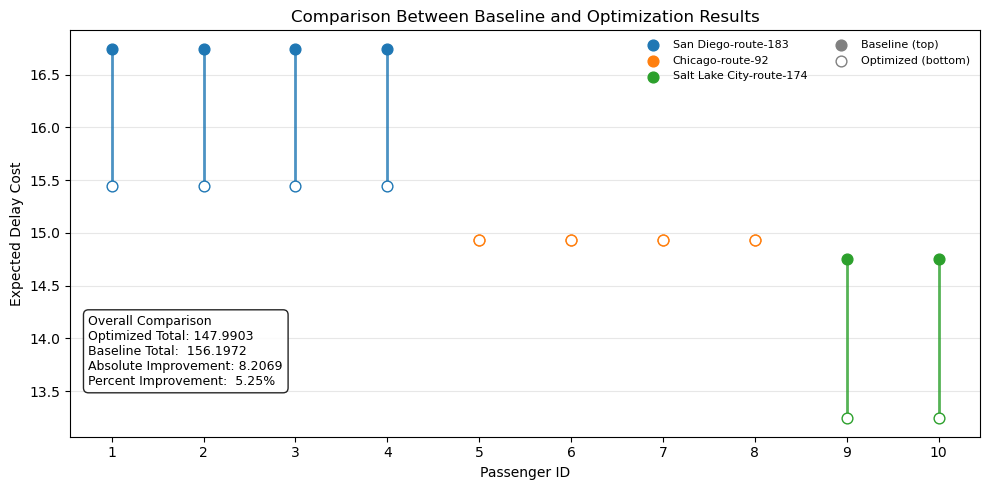

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_passengers = pd.DataFrame([
    [1,  "San Diego-route-183",        "San Diego-route-183",       16.745200, 15.447918],
    [2,  "San Diego-route-183",        "San Diego-route-183",       16.745200, 15.447918],
    [3,  "San Diego-route-183",        "San Diego-route-183",       16.745200, 15.447918],
    [4,  "San Diego-route-183",        "San Diego-route-183",       16.745200, 15.447918],
    [5,  "Chicago-route-92",           "Chicago-route-92",         14.928158, 14.928158],
    [6,  "Chicago-route-92",           "Chicago-route-92",         14.928158, 14.928158],
    [7,  "Chicago-route-92",           "Chicago-route-92",         14.928158, 14.928158],
    [8,  "Chicago-route-92",           "Chicago-route-92",         14.928158, 14.928158],
    [9,  "Salt Lake City-route-174",   "Salt Lake City-route-174",  14.751860, 13.242990],
    [10, "Salt Lake City-route-174",   "Salt Lake City-route-174",  14.751860, 13.242990],
], columns=["passenger_id", "route_name", "destination", "baseline_metric", "optimized_metric"])

# Nice colors per route
route_colors = {
    "San Diego-route-183": "tab:blue",
    "Chicago-route-92": "tab:orange",
    "Salt Lake City-route-174": "tab:green",
}
df_passengers["color"] = df_passengers["route_name"].map(route_colors)

# Precomputed totals
baseline_total = 156.1972
optimized_total = 147.9903
abs_improvement = 8.2069
pct_improvement = 5.25

x = np.arange(len(df_passengers))

fig, ax = plt.subplots(figsize=(10,5))

# Draw vertical segments + points
for i, row in df_passengers.iterrows():
    xi = x[i]
    base = row["baseline_metric"]
    opt = row["optimized_metric"]
    c = row["color"]

    ax.plot([xi, xi], [opt, base], color=c, linewidth=2, alpha=0.8)
    ax.scatter(xi, base, color=c, zorder=3, s=60)
    ax.scatter(xi, opt, color="white", edgecolor=c, zorder=3, s=60)

# Axis labels & title
ax.set_xticks(x)
ax.set_xticklabels(df_passengers["passenger_id"])
ax.set_xlabel("Passenger ID")
ax.set_ylabel("Expected Delay Cost")
ax.set_title("Comparison Between Baseline and Optimization Results")
ax.grid(axis="y", alpha=0.3)

# Route legend
for route, c in route_colors.items():
    ax.scatter([], [], color=c, s=60, label=route)

# Baseline/Optimized legend
ax.scatter([], [], color="grey", s=60, label="Baseline (top)")
ax.scatter([], [], color="white", edgecolor="grey", s=60, label="Optimized (bottom)")

ax.legend(frameon=False, fontsize=8, ncol=2, loc="upper right")

# -------------------------------
#  SUMMARY BOX ANNOTATION
# -------------------------------

summary_text = (
    f"Overall Comparison\n"
    f"Optimized Total: {optimized_total:.4f}\n"
    f"Baseline Total:  {baseline_total:.4f}\n"
    f"Absolute Improvement: {abs_improvement:.4f}\n"
    f"Percent Improvement:  {pct_improvement:.2f}%"
)

ax.text(
    0.02, 0.3,                # x,y in axes coordinates
    summary_text,
    transform=ax.transAxes,
    fontsize=9,
    va='top',
    ha='left',
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.4',
        alpha=0.85
    )
)

plt.tight_layout()
plt.show()


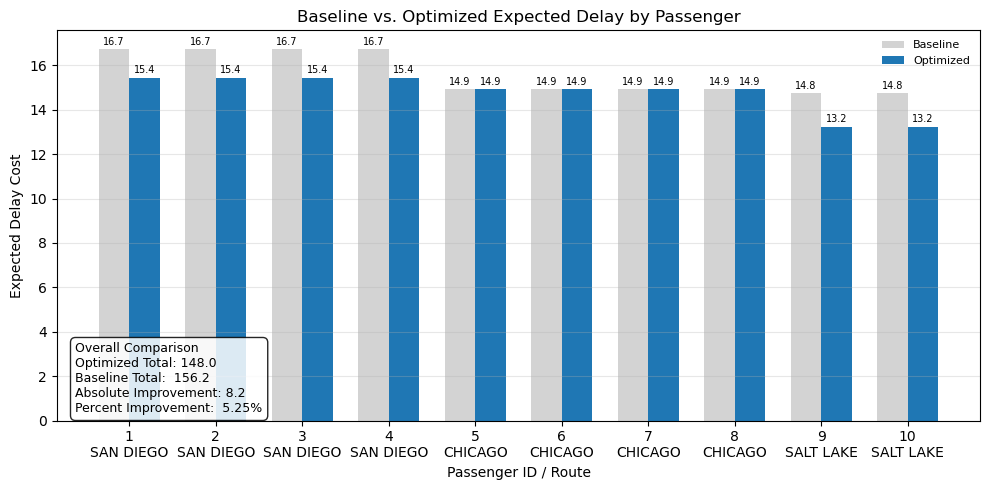

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_passengers = pd.DataFrame([
    [1,  "San Diego-route-183",        "San Diego-route-183",       16.745200, 15.447918],
    [2,  "San Diego-route-183",        "San Diego-route-183",       16.745200, 15.447918],
    [3,  "San Diego-route-183",        "San Diego-route-183",       16.745200, 15.447918],
    [4,  "San Diego-route-183",        "San Diego-route-183",       16.745200, 15.447918],
    [5,  "Chicago-route-92",           "Chicago-route-92",          14.928158, 14.928158],
    [6,  "Chicago-route-92",           "Chicago-route-92",          14.928158, 14.928158],
    [7,  "Chicago-route-92",           "Chicago-route-92",          14.928158, 14.928158],
    [8,  "Chicago-route-92",           "Chicago-route-92",          14.928158, 14.928158],
    [9,  "Salt Lake City-route-174",   "Salt Lake City-route-174",  14.751860, 13.242990],
    [10, "Salt Lake City-route-174",   "Salt Lake City-route-174",  14.751860, 13.242990],
], columns=["passenger_id", "route_name", "destination",
           "baseline_metric", "optimized_metric"])

# Short route labels for x-axis annotation
route_short = {
    "San Diego-route-183": "SAN DIEGO",
    "Chicago-route-92": "CHICAGO",
    "Salt Lake City-route-174": "SALT LAKE",
}
df_passengers["route_short"] = df_passengers["route_name"].map(route_short)

# Precomputed totals
baseline_total = 156.2
optimized_total = 148
abs_improvement = 8.2
pct_improvement = 5.25 

# Positions for grouped bars
n = len(df_passengers)
x = np.arange(n)
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))

# Bars
bars_base = ax.bar(x - width/2,
                   df_passengers["baseline_metric"],
                   width,
                   label="Baseline",
                   color="lightgray")

bars_opt = ax.bar(x + width/2,
                  df_passengers["optimized_metric"],
                  width,
                  label="Optimized",
                  color="tab:blue")

# Annotate bar values (optional, looks nice in report)
for bar in list(bars_base) + list(bars_opt):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.1,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=7
    )

# X-axis labels: passenger ID + route shorthand
xticks = [f"{pid}\n{r}"
          for pid, r in zip(df_passengers["passenger_id"], df_passengers["route_short"])]

ax.set_xticks(x)
ax.set_xticklabels(xticks)
ax.set_xlabel("Passenger ID / Route")
ax.set_ylabel("Expected Delay Cost")
ax.set_title("Baseline vs. Optimized Expected Delay by Passenger")

ax.grid(axis="y", alpha=0.3)
ax.legend(frameon=False, fontsize=8, loc="upper right")

# Summary box
summary_text = (
    "Overall Comparison\n"
    f"Optimized Total: {optimized_total:.1f}\n"
    f"Baseline Total:  {baseline_total:.1f}\n"
    f"Absolute Improvement: {abs_improvement:.1f}\n"
    f"Percent Improvement:  {pct_improvement:.2f}%"
)

ax.text(
    0.02, 0.2,
    summary_text,
    transform=ax.transAxes,
    fontsize=9,
    va="top",
    ha="left",
    bbox=dict(
        facecolor="white",
        edgecolor="black",
        boxstyle="round,pad=0.4",
        alpha=0.85,
    ),
)

plt.tight_layout()
plt.show()
